<a href="https://colab.research.google.com/github/ChiaraDropper/pclT/blob/main/pointnet_28072025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Installa versioni compatibili e stabili di torch e torchvision
!pip install --quiet --no-cache-dir torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118

# Conferma la versione
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)


!pip install numpy matplotlib
# Pulisce tutto e installa versioni compatibili
!pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118

# PointNet per classificazione ToF (empty, closed_door, one_person, two_people)

#import numpy as np
import math
import random
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Fix seed
#random.seed(42)


Torch: 2.0.1+cu118
Torchvision: 0.15.2+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118


In [34]:
!unzip -q /content/TofNetDataset_clean.zip -d /content/dataset


In [35]:
# === STABILITY SEED ===
import random, numpy as np, torch
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)


In [36]:
!pip install numpy==1.26.4
import numpy as np


import numpy as np

KeyboardInterrupt: 

augmentatio

In [46]:
# === TRANSFORMATIONS ===
class RandRotationSmallZ(object):
    def __init__(self, deg=12):
        self.deg = deg
    def __call__(self, pointcloud):
        theta = np.deg2rad(np.random.uniform(-self.deg, self.deg))
        rot_matrix = np.array([[ np.cos(theta), -np.sin(theta), 0],
                               [ np.sin(theta),  np.cos(theta), 0],
                               [ 0,              0,             1]], dtype=np.float32)
        return pointcloud @ rot_matrix.T

class RandomJitter(object):
    def __init__(self, sigma=0.003, clip=0.015):
        self.sigma, self.clip = sigma, clip
    def __call__(self, pointcloud):
        noise = np.clip(np.random.normal(0, self.sigma, pointcloud.shape), -self.clip, self.clip)
        return pointcloud + noise

class RandomScale(object):
    def __init__(self, smin=0.97, smax=1.03):
        self.smin, self.smax = smin, smax
    def __call__(self, pointcloud):
        s = np.random.uniform(self.smin, self.smax)
        return pointcloud * s

class RandomDropout(object):
    def __init__(self, p=0.06):
        self.p = p
    def __call__(self, pointcloud):
        if self.p <= 0: return pointcloud
        mask = np.random.rand(pointcloud.shape[0]) > self.p
        return pointcloud[mask] if mask.any() else pointcloud


In [48]:
# === TRANSFORMATIONS ===
class PointSampler(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, pointcloud):
        if pointcloud.shape[0] >= self.output_size:
            indices = np.random.choice(pointcloud.shape[0], self.output_size, replace=False)
        else:
            indices = np.random.choice(pointcloud.shape[0], self.output_size, replace=True)
        return pointcloud[indices, :]

class Normalize(object):
    def __call__(self, pointcloud):
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
        return norm_pointcloud



class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud).float()

# === DATASET ===

class ToFDoorBinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.velo_dir = os.path.join(root_dir, 'velodyne')
        self.label_dir = os.path.join(root_dir, 'label_2')
        self.transform = transform

        self.label_map = {
            'none': 0,
            'one_person': 1,
            'two_people': 2
            }

        self.samples = []
        for fname in sorted(os.listdir(self.velo_dir)):
            if fname.endswith('.bin'):
                bin_path = os.path.join(self.velo_dir, fname)
                txt_path = os.path.join(self.label_dir, fname.replace('.bin', '.txt'))
                if os.path.exists(txt_path):
                    self.samples.append((bin_path, txt_path))

                # memorizza le label come interi per ogni sample (serve per split stratificato e pesi)
        self.labels = []
        for _, txt_path in self.samples:
            with open(txt_path, 'r') as f:
                line = f.readline().strip()
                if not line:
                    label_str = 'none'
                else:
                    label_str = line.split()[0]
            self.labels.append(self.label_map.get(label_str, 0))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        bin_path, txt_path = self.samples[idx]

        # Carica point cloud da .bin (N, 4) → prendi solo x,y,z
        pc = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]

        # Leggi label da txt
        with open(txt_path, 'r') as f:
          lines = f.readlines()
          if not lines or lines[0].strip() == '':
              label_str = 'none'
          else:
              label_str = lines[0].strip().split()[0]

          #DEBUG print(f"Letto dal file {txt_path}: '{label_str}'")


          label = self.label_map.get(label_str, 0)




        if self.transform:
            pc = self.transform(pc)
        pc = torch.tensor(pc, dtype=torch.float32)  # qui converte in tensor
        return {'pointcloud': pc, 'category': label, 'bin_path': bin_path}


        #print("Etichette trovate nel dataset:")
        for _, txt_path in self.samples:
            with open(txt_path, 'r') as f:
                label_str = f.readline().strip()
                if not label_str:
                    label_str = 'none'
                #print(label_str)




        return {'pointcloud': pc, 'category': label, 'bin_path': bin_path}


# === POINTNET MODEL ===
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        bs = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2)[0]
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        iden = torch.eye(self.k).repeat(bs, 1, 1).to(x.device)
        x = x.view(-1, self.k, self.k) + iden
        return x

class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        matrix3x3 = self.input_transform(x)
        x = torch.bmm(matrix3x3, x)
        x = F.relu(self.bn1(self.conv1(x)))
        matrix64x64 = self.feature_transform(x)
        x = torch.bmm(matrix64x64, x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2)[0]
        return x, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x, m3x3, m64x64 = self.transform(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return self.logsoftmax(x), m3x3, m64x64

# === LOSS ===
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = nn.NLLLoss(weight=class_weights)  # <<— pesi di classe
    bs = outputs.size(0)
    id3x3 = torch.eye(3).repeat(bs, 1, 1).to(outputs.device)
    id64x64 = torch.eye(64).repeat(bs, 1, 1).to(outputs.device)
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1,2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)

# === TRAINING ===
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pointnet = PointNet().to(device)
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

from sklearn.metrics import f1_score

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)

def eval_on(loader):
    pointnet.eval()
    correct = total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = batch['pointcloud'].to(device)
            labels = batch['category'].to(device)
            outputs, _, _ = pointnet(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy()); y_pred.extend(preds.cpu().numpy())
    acc = 100.0 * correct / max(total,1)
    f1m = f1_score(y_true, y_pred, average='macro') if total>0 else 0.0
    return acc, f1m

def train(model, train_loader, val_loader=None, epochs=20, save=True):
    best_f1, bad, patience = 0.0, 0, 3
    for epoch in range(epochs):
        model.train()
        running = 0.0
        for i, batch in enumerate(train_loader):
            inputs = batch['pointcloud'].to(device)
            labels = batch['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            running += loss.item()
            if (i+1) % 10 == 0:
                print(f"[Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}] loss: {running/10:.3f}")
                running = 0.0

        if val_loader:
            acc, f1m = eval_on(val_loader)
            print(f"Validation accuracy: {acc:.2f}% | F1-macro: {f1m:.4f}")
            if f1m > best_f1:
                best_f1, bad = f1m, 0
                if save: torch.save(model.state_dict(), "pointnet_best.pth")
            else:
                bad += 1
                if bad >= patience:
                    print("Early stopping."); break

        scheduler.step()

    if save:
        torch.save(model.state_dict(), "pointnet_last.pth")


# === ESEMPIO USO ===
#train_transforms = transforms.Compose([
 #   PointSampler(1024), Normalize(), RandRotation_z(), RandomNoise(), ToTensor()
#])

#nuove augmentation
train_transforms = transforms.Compose([
    Normalize(),
    RandRotationSmallZ(deg=12),
    RandomScale(0.97, 1.03),
    RandomJitter(0.003, 0.015),
    RandomDropout(0.06),
    PointSampler(1024) # Moved PointSampler here
    # ❌ niente ToTensor qui
])

val_transforms = transforms.Compose([
    Normalize(),
    PointSampler(1024) # PointSampler remains here
    # ❌ niente ToTensor qui
])



#train_dataset = ToFDoorBinDataset('/content/dataset/training', transform=train_transforms)
#from torch.utils.data import random_split

# Dataset intero
#full_dataset = ToFDoorBinDataset('/content/dataset/TofNetDataset_clean/training', transform=train_transforms)

# Suddividi 80% training, 20% validation
#train_size = int(0.8 * len(full_dataset))
#val_size = len(full_dataset) - train_size
#train_dataset, valid_dataset = random_split(full_dataset, [train_size, val_size])

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=64)

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

# Dataset base (senza transform qui, le applichiamo coi subset)
full_dataset = ToFDoorBinDataset('/content/dataset/TofNetDataset_clean/training', transform=None)

labels_all = np.array(full_dataset.labels)
idx_all = np.arange(len(full_dataset))
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(idx_all, labels_all))


from collections import Counter
train_labels = [full_dataset.labels[i] for i in train_idx]
cnt = Counter(train_labels)
K = 3
N = sum(cnt.values())
w = np.array([N / (K * max(cnt.get(c, 1), 1)) for c in range(K)], dtype=np.float32)
w = np.clip(w, 0.5, 2.0)
class_weights = torch.tensor(w, device=device)
print("Class weights:", w)

class TransformingSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super().__init__(dataset, indices)
        self.dataset = dataset
        self.transform = transform
    def __getitem__(self, i):
      sample = super().__getitem__(i)
      pc, label, bin_path = sample['pointcloud'], sample['category'], sample['bin_path']

      # 🔒 garantisco numpy
      pc = np.array(pc, dtype=np.float32)

      # applico augmentation
      if self.transform:
          pc = self.transform(pc)

      # converto a torch solo alla fin
      pc = torch.tensor(pc, dtype=torch.float32)

      return {'pointcloud': pc, 'category': label, 'bin_path': bin_path}


train_transforms = transforms.Compose([
    Normalize(),
    RandRotationSmallZ(deg=12),
    RandomScale(0.97, 1.03),
    RandomJitter(0.003, 0.015),
    RandomDropout(0.06),
    PointSampler(1024) # Moved PointSampler here
])

val_transforms = transforms.Compose([
    Normalize(),
    PointSampler(1024) # PointSampler remains here
])

train_dataset = TransformingSubset(full_dataset, train_idx, train_transforms)
valid_dataset = TransformingSubset(full_dataset, val_idx, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)


train(pointnet, train_loader, valid_loader, save=True)

# Puoi aggiungere valutazione e salvataggio modello dopo questa cella
def get_label_centroid(txt_path):
    with open(txt_path, 'r') as f:
        line = f.readline().strip()
        if not line:
            return None
        parts = line.split()
        if len(parts) < 14:
            return None
        try:
            # location_x, location_y, location_z
            x, y, z = map(float, parts[11:14])
            return np.array([x, y, z])
        except:
            return None
previous_center = None
in_count = 0
out_count = 0
axis = 1  # usa 1 per asse Y, oppure 2 per asse Z
delta_threshold = 100  # soglia in mm per movimento reale

def track_from_labels(current_center, frame_id):
    global previous_center, in_count, out_count

    if current_center is None:
        print(f"[Frame {frame_id}] → Nessun centroide")
        return

    if previous_center is not None:
        delta = current_center[axis] - previous_center[axis]
        if abs(delta) > delta_threshold:
            if delta > 0:
                print(f"[Frame {frame_id}] → Entrata (Δ = {delta:.1f} mm)")
                in_count += 1
            else:
                print(f"[Frame {frame_id}] → Uscita (Δ = {delta:.1f} mm)")
                out_count += 1
        else:
            print(f"[Frame {frame_id}] → Movimento troppo piccolo (Δ = {delta:.1f} mm)")
    else:
        print(f"[Frame {frame_id}] → Primo centroide registrato")

    previous_center = current_center

Class weights: [1.0245211 0.7378587 1.4955257]
[Epoch 1, Batch 10/41] loss: 0.924
[Epoch 1, Batch 20/41] loss: 0.579
[Epoch 1, Batch 30/41] loss: 0.475
[Epoch 1, Batch 40/41] loss: 0.453
Validation accuracy: 42.69% | F1-macro: 0.4306
[Epoch 2, Batch 10/41] loss: 0.281
[Epoch 2, Batch 20/41] loss: 0.305
[Epoch 2, Batch 30/41] loss: 0.270
[Epoch 2, Batch 40/41] loss: 0.271
Validation accuracy: 91.34% | F1-macro: 0.9077
[Epoch 3, Batch 10/41] loss: 0.237
[Epoch 3, Batch 20/41] loss: 0.254
[Epoch 3, Batch 30/41] loss: 0.185
[Epoch 3, Batch 40/41] loss: 0.247
Validation accuracy: 86.87% | F1-macro: 0.8667
[Epoch 4, Batch 10/41] loss: 0.194
[Epoch 4, Batch 20/41] loss: 0.207
[Epoch 4, Batch 30/41] loss: 0.175
[Epoch 4, Batch 40/41] loss: 0.164
Validation accuracy: 96.12% | F1-macro: 0.9574
[Epoch 5, Batch 10/41] loss: 0.170
[Epoch 5, Batch 20/41] loss: 0.209
[Epoch 5, Batch 30/41] loss: 0.167
[Epoch 5, Batch 40/41] loss: 0.192
Validation accuracy: 96.12% | F1-macro: 0.9579
[Epoch 6, Batch 10

In [49]:

def get_label_centroid(txt_path):
    with open(txt_path, 'r') as f:
        line = f.readline().strip()
        if not line:
            return None
        parts = line.split()
        if len(parts) < 14:
            return None
        try:
            # location_x, location_y, location_z
            x, y, z = map(float, parts[11:14])
            return np.array([x, y, z])
        except:
            return None
previous_center = None
in_count = 0
out_count = 0
axis = 1  # usa 1 per asse Y, oppure 2 per asse Z
delta_threshold = 100  # soglia in mm per movimento reale

def track_from_labels(current_center, frame_id):
    global previous_center, in_count, out_count

    if current_center is None:
        print(f"[Frame {frame_id}] → Nessun centroide")
        return

    if previous_center is not None:
        delta = current_center[axis] - previous_center[axis]
        if abs(delta) > delta_threshold:
            if delta > 0:
                print(f"[Frame {frame_id}] → Entrata (Δ = {delta:.1f} mm)")
                in_count += 1
            else:
                print(f"[Frame {frame_id}] → Uscita (Δ = {delta:.1f} mm)")
                out_count += 1
        else:
            print(f"[Frame {frame_id}] → Movimento troppo piccolo (Δ = {delta:.1f} mm)")
    else:
        print(f"[Frame {frame_id}] → Primo centroide registrato")

    previous_center = current_center

!pip install plotly
import plotly.graph_objects as go
import random

def visualize_prediction(model, dataset, index=None):
    model.eval()
    if index is None:
        index = random.randint(0, len(dataset)-1)

    sample = dataset[index]
    pointcloud = sample['pointcloud'].unsqueeze(0).to(device)  # (1, N, 3)
    true_label = sample['category']

    with torch.no_grad():
        output, _, _ = model(pointcloud.transpose(1, 2))
        pred_label = output.max(dim=1)[1].item()

    # Convert to numpy for plotting
    pc_np = pointcloud.squeeze(0).cpu().numpy()
    x, y, z = pc_np[:, 0], pc_np[:, 1], pc_np[:, 2]

    label_map = ['none', 'one_person', 'two_people']
    true_label_str = label_map[true_label]
    pred_label_str = label_map[pred_label]
    # Aggiungi dopo aver ottenuto pred_label_str



    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=2, color=z, colorscale='Viridis'),
        name='Point Cloud'
    ))

    fig.update_layout(
        title=f"<b>Predicted:</b> {pred_label_str} &nbsp;&nbsp;&nbsp;&nbsp; <b>Ground Truth:</b> {true_label_str}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()


In [50]:
def infer_direction_tracking(current_pc, frame_id):
    global previous_center, frame_counter, in_count, out_count

    # Calcola centroide 3D attuale
    current_center = np.mean(current_pc, axis=0)

    if previous_center is not None:
        # Verifica se è la stessa persona (distanza spaziale)
        distance = np.linalg.norm(current_center - previous_center)

        if distance < DISTANCE_THRESHOLD:
            delta = current_center[DIRECTION_AXIS] - previous_center[DIRECTION_AXIS]

            if abs(delta) > DIRECTION_THRESHOLD:
                if delta > 0:
                    print(f"[Frame {frame_id}] → Entrata (Δ = {delta:.1f} mm)")
                    in_count += 1
                else:
                    print(f"[Frame {frame_id}] → Uscita (Δ = {delta:.1f} mm)")
                    out_count += 1
            else:
                print(f"[Frame {frame_id}] → Movimento troppo piccolo (Δ = {delta:.1f} mm)")
        else:
            print(f"[Frame {frame_id}] → Ignorato: nuova persona (Δcentro = {distance:.1f} mm)")

    else:
        print(f"[Frame {frame_id}] → Primo centroide registrato.")

    # aggiorna stato
    previous_center = current_center
    frame_counter += 1




In [51]:

# Stato del tracking
previous_center = None
frame_counter = 0
in_count = 0
out_count = 0
DIRECTION_AXIS = 1   # 1 = asse Y (dipende dalla tua scena)
DIRECTION_THRESHOLD = 150  # minimo movimento significativo in mm
DISTANCE_THRESHOLD = 300   # distanza massima per dire che è la stessa persona

# Visualizzazione random
visualize_prediction(pointnet, valid_dataset)

# Oppure specifica un indice, es: il terzo esempio
visualize_prediction(pointnet, valid_dataset, index=20)


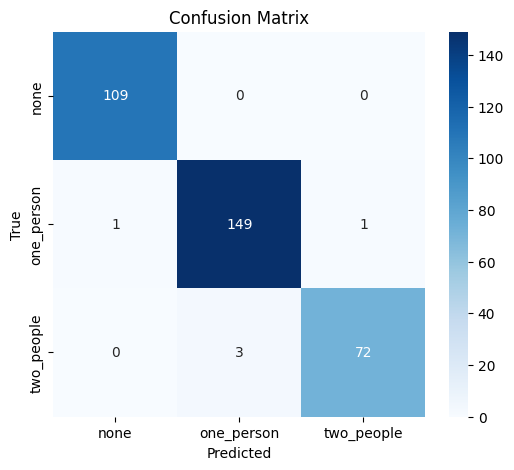


📊 Classification Report:
              precision    recall  f1-score     support
none           0.990909  1.000000  0.995434  109.000000
one_person     0.980263  0.986755  0.983498  151.000000
two_people     0.986301  0.960000  0.972973   75.000000
accuracy       0.985075  0.985075  0.985075    0.985075
macro avg      0.985825  0.982252  0.983968  335.000000
weighted avg   0.985079  0.985075  0.985025  335.000000

❌ Number of misclassified examples: 5


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Classi
label_names = ['none', 'one_person', 'two_people']

def evaluate_model(model, dataloader, label_names, show_cm=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['pointcloud'].to(device)
            labels = batch['category'].to(device)
            outputs, _, _ = model(inputs.transpose(1, 2))
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=label_names, digits=3, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    if show_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    print("\n📊 Classification Report:")
    print(report_df)

    # Salva casi errati
    wrong_preds = [(true, pred) for true, pred in zip(all_labels, all_preds) if true != pred]
    print(f"\n❌ Number of misclassified examples: {len(wrong_preds)}")

    return report_df, cm, all_preds, all_labels



report_df, cm, preds, labels = evaluate_model(pointnet, valid_loader, label_names)


In [53]:
# STEP 1 — Trova gli indici dei frame classificati male
wrong_indices = []

for i in range(len(valid_dataset)):
    sample = valid_dataset[i]
    pc = sample['pointcloud'].unsqueeze(0).to(device)
    true_label = sample['category']

    with torch.no_grad():
        output, _, _ = pointnet(pc.transpose(1, 2))
        pred_label = output.max(dim=1)[1].item()

    if pred_label != true_label:
        bin_path, txt_path = valid_dataset.dataset.samples[valid_dataset.indices[i]]
        wrong_indices.append((i, pred_label, true_label, bin_path, txt_path))

# STEP 2 — Visualizza primi N errori (modifica N se vuoi)
print(f"\n❌ TOT errori: {len(wrong_indices)} — ora visualizzo i primi 5...\n")

for i, (index, pred, true, bin_path, txt_path) in enumerate(wrong_indices):
    print(f"[{i+1}] Index {index} — Pred: {label_names[pred]} | True: {label_names[true]}")
    print(f"     File: {bin_path}")
    visualize_prediction(pointnet, valid_dataset, index=index)



❌ TOT errori: 4 — ora visualizzo i primi 5...

[1] Index 59 — Pred: two_people | True: one_person
     File: /content/dataset/TofNetDataset_clean/training/velodyne/107146.bin


[2] Index 70 — Pred: one_person | True: two_people
     File: /content/dataset/TofNetDataset_clean/training/velodyne/107049.bin


[3] Index 101 — Pred: one_person | True: two_people
     File: /content/dataset/TofNetDataset_clean/training/velodyne/001071.bin


[4] Index 257 — Pred: none | True: one_person
     File: /content/dataset/TofNetDataset_clean/training/velodyne/107152.bin


In [54]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("misclassified_png", exist_ok=True)
label_names = ['none', 'one_person', 'two_people']

def softmax_np(logits):
    x = logits - logits.max(axis=1, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=1, keepdims=True)

def save_pc_png(points, title, out_path):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0.5)
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close(fig)

def dump_misclassified(model, dataset, loader, out_csv="misclassified.csv"):
    model.eval()
    rows = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            X = batch['pointcloud'].to(device)
            y = batch['category'].cpu().numpy()
            # prendo anche i path originali (occhio: random_split -> serve mappare indices)
            # Estraggo i bin_path allineati al batch:
            if hasattr(batch, 'keys') and 'bin_path' in batch:
                bin_paths = batch['bin_path']
            else:
                # ricavo dai subset indices:
                subset = loader.dataset  # Subset
                base_ds = subset.dataset
                bin_paths = [ base_ds.samples[ subset.indices[batch_idx*loader.batch_size + i] ][0]
                              for i in range(len(y)) if batch_idx*loader.batch_size + i < len(subset.indices) ]

            logits, _, _ = model(X.transpose(1,2))
            logits_np = logits.cpu().numpy()
            probs = softmax_np(logits_np)
            preds = probs.argmax(1)

            for i in range(len(y)):
                true_lbl = label_names[y[i]]
                pred_lbl = label_names[preds[i]]
                conf = float(probs[i, preds[i]])
                fid = os.path.splitext(os.path.basename(bin_paths[i]))[0]

                row = dict(frame_id=fid, y_true=true_lbl, y_pred=pred_lbl, conf=conf, bin_path=bin_paths[i])
                if true_lbl != pred_lbl:
                    # salva PNG anteprima
                    pts = np.fromfile(bin_paths[i], dtype=np.float32).reshape(-1,4)[:, :3]
                    png_path = f"misclassified_png/{fid}_true-{true_lbl}_pred-{pred_lbl}.png"
                    save_pc_png(pts, f"{fid} | true:{true_lbl} pred:{pred_lbl} | N={len(pts)}", png_path)
                    row["png"] = png_path
                else:
                    row["png"] = ""
                rows.append(row)

    df = pd.DataFrame(rows)
    mis = df[df.y_true != df.y_pred].sort_values(["y_true","conf"])
    df.to_csv("all_predictions.csv", index=False)
    mis.to_csv(out_csv, index=False)
    print(f"💾 Salvati: {out_csv}, all_predictions.csv e PNG in misclassified_png/")
    print(f"❌ Misclassified: {len(mis)}")
    return mis, df


In [55]:
mis, all_df = dump_misclassified(pointnet, valid_dataset, valid_loader)


💾 Salvati: misclassified.csv, all_predictions.csv e PNG in misclassified_png/
❌ Misclassified: 3


              precision    recall  f1-score    support
none           0.990909  1.000000  0.995434  109.00000
one_person     0.973856  0.986755  0.980263  151.00000
two_people     0.986111  0.946667  0.965986   75.00000
accuracy       0.982090  0.982090  0.982090    0.98209
macro avg      0.983625  0.977807  0.980561  335.00000
weighted avg   0.982148  0.982090  0.982003  335.00000


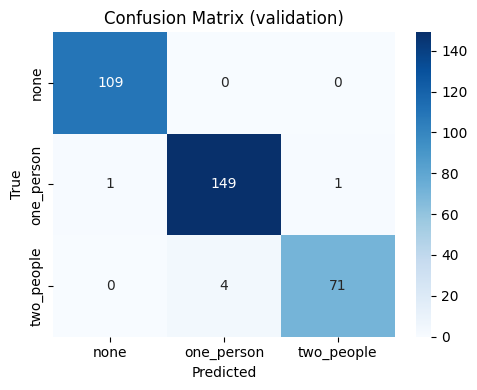

In [56]:
# STEP 1 — Valutazione del best checkpoint su validation set

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1) ricarica il modello migliore
best = PointNet().to(device)
best.load_state_dict(torch.load("pointnet_best.pth", map_location=device))
best.eval()

# 2) raccogli predizioni e target
label_names = ['none','one_person','two_people']
y_true, y_pred = [], []

with torch.no_grad():
    for batch in valid_loader:
        X = batch['pointcloud'].to(device)        # (B, 1024, 3)
        y = batch['category'].to(device)          # (B,)
        out, _, _ = best(X.transpose(1,2))        # PointNet vuole (B, 3, 1024)
        pred = out.argmax(1)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

# 3) classification report per classe
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, digits=3)
print(pd.DataFrame(report).T)

# 4) confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (validation)")
plt.tight_layout()
plt.show()


In [58]:
# ==== STEP 2: salva artefatti di valutazione e riproducibilità ====

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

os.makedirs("artifacts", exist_ok=True)

# 0) ricarica BEST checkpoint (se non è già in RAM)
best = PointNet().to(device)
best.load_state_dict(torch.load("pointnet_best.pth", map_location=device))
best.eval()

label_names = ['none','one_person','two_people']

# 1) raccogli predizioni e target sul validation set corrente
y_true, y_pred = [], []
with torch.no_grad():
    for batch in valid_loader:
        X = batch['pointcloud'].to(device)          # (B,1024,3)
        y = batch['category'].to(device)            # (B,)
        out, _, _ = best(X.transpose(1,2))          # (B,C)
        pred = out.argmax(1)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

# 2) classification report → CSV
report_dict = classification_report(
    y_true, y_pred, target_names=label_names, output_dict=True, digits=3
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("artifacts/classification_report_val.csv", index=True)
print("✅ Salvato artifacts/classification_report_val.csv")

# 3) confusion matrix → PNG
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (validation)")
plt.tight_layout()
plt.savefig("artifacts/confusion_matrix_val.png", dpi=300)
plt.close()
print("✅ Salvato artifacts/confusion_matrix_val.png")

# 4) salva split train/val come liste di file (bin paths) + indici .npy
#    (richiede che 'full_dataset', 'train_idx', 'val_idx' esistano come nel training)
train_paths = [ full_dataset.samples[i][0] for i in train_idx ]  # .bin path
val_paths   = [ full_dataset.samples[i][0] for i in val_idx ]

with open("artifacts/train_split.txt", "w") as f:
    for p in train_paths: f.write(p + "\n")
with open("artifacts/val_split.txt", "w") as f:
    for p in val_paths: f.write(p + "\n")
np.save("artifacts/train_idx.npy", np.array(train_idx))
np.save("artifacts/val_idx.npy",   np.array(val_idx))
print("✅ Salvati artifacts/train_split.txt, artifacts/val_split.txt, artifacts/train_idx.npy, artifacts/val_idx.npy")

# 5) salva pesi di classe usati (w) + metadati run
#    (richiede che la variabile 'w' esista dal calcolo dei class weights)
np.save("artifacts/class_weights.npy", w)
meta = {
    "seed": 42,
    "num_points": 1024,
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR(T_max=12)",
    "early_stopping_patience": 3,
    "class_weights": [float(x) for x in w],
    "val_accuracy": float(report_dict["accuracy"]),
    "val_f1_macro": float(report_df.loc["macro avg","f1-score"]),
    "counts_val_per_class": {name: int(report_df.loc[name, "support"]) for name in label_names},
}
with open("artifacts/run_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("✅ Salvati artifacts/class_weights.npy e artifacts/run_metadata.json")

# 6) misclassificati → CSV (frame_id, true, pred)
rows = []
for i, (t, p) in enumerate(zip(y_true, y_pred)):
    if t != p:
        # recupera path del sample i-esimo del validation set
        # mapping i -> indice globale:
        global_idx = val_idx[i]
        bin_path = full_dataset.samples[global_idx][0]
        fid = os.path.splitext(os.path.basename(bin_path))[0]
        rows.append({
            "frame_id": fid,
            "true": label_names[t],
            "pred": label_names[p],
            "bin_path": bin_path
        })
mis_df = pd.DataFrame(rows)
mis_df.to_csv("artifacts/misclassified_val.csv", index=False)
print(f"✅ Salvato artifacts/misclassified_val.csv  (n={len(mis_df)})")

print("\n🎉 DONE — tutti gli artefatti dello Step 2 sono in ./artifacts/")


✅ Salvato artifacts/classification_report_val.csv
✅ Salvato artifacts/confusion_matrix_val.png
✅ Salvati artifacts/train_split.txt, artifacts/val_split.txt, artifacts/train_idx.npy, artifacts/val_idx.npy
✅ Salvati artifacts/class_weights.npy e artifacts/run_metadata.json
✅ Salvato artifacts/misclassified_val.csv  (n=6)

🎉 DONE — tutti gli artefatti dello Step 2 sono in ./artifacts/


In [59]:
# STEP 3A — Inference su un singolo .bin

import os, numpy as np, torch

# Usa le stesse transform del validation: PointSampler + Normalize (già definite)
label_names = ['none','one_person','two_people']

# carica modello best
infer_model = PointNet().to(device)
infer_model.load_state_dict(torch.load("pointnet_best.pth", map_location=device))
infer_model.eval()

@torch.no_grad()
def infer_bin(path_bin):
    # carica point cloud (Nx4) -> prendi x,y,z
    pc = np.fromfile(path_bin, dtype=np.float32).reshape(-1,4)[:, :3]
    # val pipeline
    pc = PointSampler(1024)(pc)
    pc = Normalize()(pc)
    # to tensor (1, N, 3) -> (1, 3, N)
    t = torch.tensor(pc, dtype=torch.float32, device=device).unsqueeze(0).transpose(1,2)
    logprobs, _, _ = infer_model(t)
    probs = torch.exp(logprobs).squeeze(0).cpu().numpy()  # perché il modello usa LogSoftmax
    pred_idx = int(np.argmax(probs))
    return label_names[pred_idx], probs

# Esempio d'uso:
test_path = "/content/dataset/TofNetDataset_clean/training/velodyne/000123.bin"
pred, probs = infer_bin(test_path)
print(pred, probs)


none [0.9061851  0.06031862 0.03349623]


In [60]:
# STEP 3B — Inference batch su cartella .bin e salvataggio CSV

import glob, pandas as pd

def infer_folder(bin_dir, out_csv="predictions.csv"):
    rows = []
    bin_files = sorted(glob.glob(os.path.join(bin_dir, "*.bin")))
    with torch.no_grad():
        for p in bin_files:
            pred, probs = infer_bin(p)
            fid = os.path.splitext(os.path.basename(p))[0]
            rows.append({
                "frame_id": fid,
                "bin_path": p,
                "pred": pred,
                "p_none": float(probs[0]),
                "p_one_person": float(probs[1]),
                "p_two_people": float(probs[2]),
            })
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"✅ Salvato {out_csv} con {len(rows)} righe.")
    return df

# Esempio d'uso:
infer_folder("/content/dataset/TofNetDataset_clean/training/velodyne", out_csv="predictions_val.csv")


✅ Salvato predictions_val.csv con 1672 righe.


,frame_id,bin_path,pred,p_none,p_one_person,p_two_people
0,000000,/content/dataset/TofNetDataset_clean/training/...,none,0.999376,0.000377,0.000248
1,000001,/content/dataset/TofNetDataset_clean/training/...,none,0.999333,0.000397,0.000270
2,000002,/content/dataset/TofNetDataset_clean/training/...,none,0.998733,0.000775,0.000493
3,000003,/content/dataset/TofNetDataset_clean/training/...,none,0.998604,0.000840,0.000556
4,000004,/content/dataset/TofNetDataset_clean/training/...,none,0.999272,0.000443,0.000284
...,...,...,...,...,...,...
1667,107329,/content/dataset/TofNetDataset_clean/training/...,two_people,0.000148,0.002399,0.997454
1668,107330,/content/dataset/TofNetDataset_clean/training/...,two_people,0.000203,0.003060,0.996738
1669,107331,/content/dataset/TofNetDataset_clean/training/...,two_people,0.000601,0.010118,0.989281
1670,107332,/content/dataset/TofNetDataset_clean/training/...,two_people,0.001036,0.011278,0.987686


In [63]:
# Wrapper di export: solo logprobs
class PointNetExport(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base.eval()
    def forward(self, x):           # x: (B,3,N)
        logprobs, _, _ = self.base(x)
        return logprobs             # solo il primo output

# Carica best
base = PointNet().to(device)
base.load_state_dict(torch.load("pointnet_best.pth", map_location=device))
base.eval()

export_ts = PointNetExport(base).to(device)

# Trace + save
NPTS = 1024
dummy = torch.randn(1, 3, NPTS, device=device)
with torch.no_grad():
    ts_traced = torch.jit.trace(export_ts, dummy)
ts_traced.save("pointnet_best.ts")
print("✅ Salvato TorchScript -> pointnet_best.ts (solo logprobs)")

# Test coerenza
with torch.no_grad():
    out_ref, _, _ = base(dummy)
    out_ts = ts_traced(dummy)  # già solo logprobs
diff = (out_ref - out_ts).abs().max().item()
print(f"Delta max TorchScript vs PyTorch: {diff:.6f}")


✅ Salvato TorchScript -> pointnet_best.ts (solo logprobs)
Delta max TorchScript vs PyTorch: 0.000000


In [70]:
# STEP 4B — Export ONNX (.onnx) con assi dinamici + test con PyTorch confronto numerico


!pip install onnx onnxruntime
import torch
import numpy as np

onnx_model_path = "pointnet_best.onnx"

# 1) modello in eval
onnx_model = PointNet().to(device)
onnx_model.load_state_dict(torch.load("pointnet_best.pth", map_location=device))
onnx_model.eval()

# 2) dummy input (B,3,N) — abilitiamo batch e num_points dinamici
B, NPTS = 1, 1024
dummy = torch.randn(B, 3, NPTS, device=device)

# 3) export
torch.onnx.export(
    onnx_model, dummy,
    onnx_model_path,
    input_names=["points_ch3"],          # (B,3,N)
    output_names=["logprobs"],           # LogSoftmax
    dynamic_axes={"points_ch3": {0: "batch", 2: "num_points"},
                  "logprobs":   {0: "batch"}},
    opset_version=13,
    do_constant_folding=True
)
print(f"✅ Salvato ONNX -> {onnx_model_path}")

# 4) confronto PyTorch vs ONNXRuntime numerico (facoltativo se usi la cella 4C)
with torch.no_grad():
    torch_out, _, _ = onnx_model(dummy)        # log-probabilities
torch_out_np = torch_out.detach().cpu().numpy()
print("PyTorch output shape:", torch_out_np.shape)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ Salvato ONNX -> pointnet_best.onnx
PyTorch output shape: (1, 3)


In [68]:
onnx_path = "pointnet_best.onnx"
export_onnx = PointNetExport(base).to(device).eval()

dummy = torch.randn(1, 3, 1024, device=device)
torch.onnx.export(
    export_onnx, dummy, onnx_path,
    input_names=["points_ch3"],
    output_names=["logprobs"],                 # solo logprobs
    dynamic_axes={"points_ch3": {0:"batch", 2:"num_points"},
                  "logprobs":   {0:"batch"}},
    opset_version=13, do_constant_folding=True
)
print(f"✅ Salvato ONNX -> {onnx_path} (solo logprobs)")


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ Salvato ONNX -> pointnet_best.onnx (solo logprobs)


In [69]:
# STEP 4C — Verifica ONNX con onnxruntime (CPU)

!pip -q install onnxruntime

import onnxruntime as ort
import numpy as np
import torch

# sessione ORT
sess = ort.InferenceSession("pointnet_best.onnx", providers=["CPUExecutionProvider"])

# prepara input numpy (B,3,N)
B, NPTS = 1, 1024
x_np = np.random.randn(B, 3, NPTS).astype("float32")

# inferenza
out = sess.run(["logprobs"], {"points_ch3": x_np})[0]   # log-probabilities
print("ONNX output shape:", out.shape)

# converto a probabilità (come in PyTorch: LogSoftmax -> exp)
probs = np.exp(out)
print("ONNX probs sum per campione:", probs.sum(axis=1))  # ~1.0
print("✅ ONNX inference ok")


ONNX output shape: (1, 3)
ONNX probs sum per campione: [1.]
✅ ONNX inference ok


In [71]:
# ===== STEP 5A — Batch inference stand-alone (TorchScript o ONNX) =====
import os, glob, time, json, numpy as np, pandas as pd, torch

label_names = ['none','one_person','two_people']

# Preprocess identico al validation
def preprocess_bin(path_bin, npts=1024):
    pc = np.fromfile(path_bin, dtype=np.float32).reshape(-1,4)[:, :3]
    pc = PointSampler(npts)(pc)
    pc = Normalize()(pc)
    return pc  # (N,3) numpy

# ---- TorchScript runner ----
class TorchScriptRunner:
    def __init__(self, ts_path, device):
        self.device = device
        self.m = torch.jit.load(ts_path, map_location=device).eval()
    @torch.no_grad()
    def __call__(self, pc_np):
        t = torch.tensor(pc_np, dtype=torch.float32, device=self.device).unsqueeze(0).transpose(1,2)
        logp = self.m(t)              # (1,C) log-probs
        probs = torch.exp(logp)[0].cpu().numpy()
        return int(np.argmax(probs)), probs

# ---- ONNX runner (opzionale) ----
class ONNXRunner:
    def __init__(self, onnx_path):
        import onnxruntime as ort
        self.sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    def __call__(self, pc_np):
        x = pc_np.astype('float32')[None].transpose(0,2,1)  # (1,3,N)
        logp = self.sess.run(['logprobs'], {'points_ch3': x})[0][0]
        probs = np.exp(logp)
        return int(np.argmax(probs)), probs

def infer_folder_standalone(bin_dir, out_csv="predictions.csv", backend="ts",
                            model_path="pointnet_best.ts", device='cpu'):
    if backend == "ts":
        runner = TorchScriptRunner(model_path, torch.device(device))
    else:
        runner = ONNXRunner(model_path)

    rows, t0 = [], time.time()
    files = sorted(glob.glob(os.path.join(bin_dir, "*.bin")))
    for p in files:
        pc = preprocess_bin(p, npts=1024)
        pred_idx, probs = runner(pc)
        fid = os.path.splitext(os.path.basename(p))[0]
        rows.append({
            "frame_id": fid,
            "bin_path": p,
            "pred": label_names[pred_idx],
            "p_none": float(probs[0]),
            "p_one_person": float(probs[1]),
            "p_two_people": float(probs[2]),
        })
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"✅ {out_csv} salvato ({len(df)} frame) in {time.time()-t0:.2f}s  | backend={backend}")
    return df

# Esempi d’uso:
# df1 = infer_folder_standalone("/content/dataset/TofNetDataset_clean/training/velodyne",
#                               out_csv="pred_ts.csv", backend="ts",
#                               model_path="pointnet_best.ts", device='cuda' if torch.cuda.is_available() else 'cpu')
# df2 = infer_folder_standalone("/content/dataset/TofNetDataset_clean/training/velodyne",
#                               out_csv="pred_onnx.csv", backend="onnx",
#                               model_path="pointnet_best.onnx")


In [72]:
# ===== STEP 5B — Benchmark latenza (TorchScript vs ONNX) =====
import time, numpy as np, torch

def benchmark_runner(runner, warmup=10, iters=100, npts=1024, device='cpu'):
    pcs = [np.random.randn(npts,3).astype('float32') for _ in range(iters+warmup)]
    # warmup
    for i in range(warmup):
        runner(pcs[i])
    t0 = time.time()
    for i in range(warmup, warmup+iters):
        runner(pcs[i])
    t1 = time.time()
    return (t1 - t0)*1000.0/iters

# TS
ts_runner = TorchScriptRunner("pointnet_best.ts", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
ts_ms = benchmark_runner(ts_runner, iters=100)
print(f"TS: {ts_ms:.2f} ms/frame")

# ONNX
onnx_runner = ONNXRunner("pointnet_best.onnx")
onnx_ms = benchmark_runner(onnx_runner, iters=100)
print(f"ONNX: {onnx_ms:.2f} ms/frame")


TS: 1.68 ms/frame
ONNX: 9.70 ms/frame


In [73]:
# ===== STEP 5C — Prepara pacchetto artefatti (zip) =====
import shutil, os, json

os.makedirs("deliverable", exist_ok=True)

# Modelli
for f in ["pointnet_best.ts", "pointnet_best.onnx", "pointnet_best.pth"]:
    if os.path.exists(f):
        shutil.copy(f, "deliverable")

# Artefatti step 2
if os.path.exists("artifacts"):
    shutil.copytree("artifacts", "deliverable/artifacts", dirs_exist_ok=True)

# Script inference minimal (TS + ONNX)
with open("deliverable/README.txt", "w") as f:
    f.write("""CONTENUTO:
- pointnet_best.ts (TorchScript, output: logprobs)
- pointnet_best.onnx (ONNX, output: logprobs)
- pointnet_best.pth (PyTorch weights)
- artifacts/ (report, confusion matrix, split, class_weights, metadata)
USO RAPIDO (Python):
  - TorchScript:
      import torch, numpy as np
      m = torch.jit.load('pointnet_best.ts', map_location='cpu').eval()
      # pc_np: (N,3) preprocessato con PointSampler+Normalize
      t = torch.tensor(pc_np, dtype=torch.float32).unsqueeze(0).transpose(1,2)
      logp = m(t); probs = torch.exp(logp)[0].numpy()
  - ONNX:
      import onnxruntime as ort, numpy as np
      sess = ort.InferenceSession('pointnet_best.onnx', providers=['CPUExecutionProvider'])
      x = pc_np.astype('float32')[None].transpose(0,2,1)
      logp = sess.run(['logprobs'], {'points_ch3': x})[0][0]; probs = np.exp(logp)
NOTA: usare lo stesso preprocess (PointSampler(1024) + Normalize) del validation.
""")

shutil.make_archive("deliverable_bundle", "zip", "deliverable")
print("📦 creato deliverable_bundle.zip")


📦 creato deliverable_bundle.zip
